In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.insert(1, 'Trace_Profile')
import TraceModel as tm

from overlap import TrpzOverlap
from utils import grid_from_map, get_soss_grid, oversample_grid

from matplotlib.colors import LogNorm #for better display of FITS images

plt.rc('figure', figsize=(15, 3))

## Make Order 1 Profile

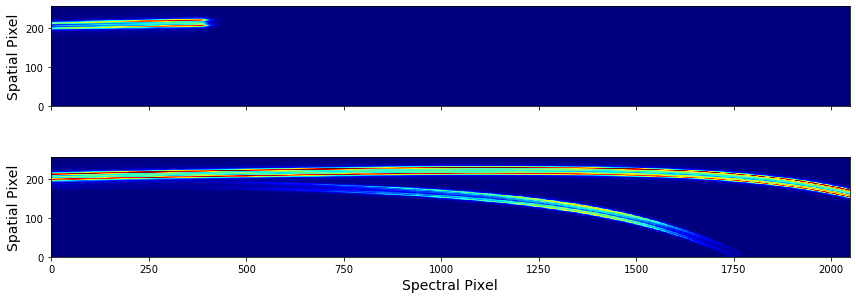

In [3]:
# Open simulated clear and F277W exposures
clear = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/clear.fits')[0].data[::-1, :]
F277 = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/f277.fits')[0].data[::-1, :]

# Visualize the frames
f, ax = plt.subplots(2, sharex=True, figsize=(12, 5))
ax[0].imshow(F277/np.nanmax(F277), origin='lower', cmap='jet')
ax[0].set_ylabel('Spatial Pixel', fontsize=14)

ax[1].imshow(clear/np.nanmax(clear, axis=0), origin='lower', cmap='jet')
ax[1].set_xlabel('Spectral Pixel', fontsize=14)
ax[1].set_ylabel('Spatial Pixel', fontsize=14)

f.tight_layout()

In [28]:
# The end user would really only need to call this one function which
# then completely creates the trace model for them.
# The above examples were just to demonstrate further how the code actually works.
# The trace model can also be written to disk by passing a file name with the 'filename' argument.
tracemodel_wf277 = tm.makemod(clear, F277, do_plots=False)

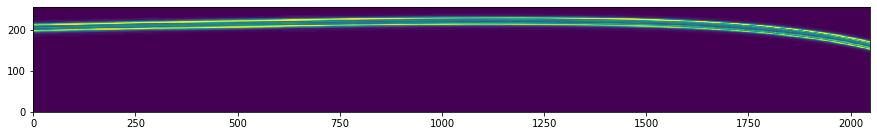

In [29]:
# Visualize the new model.
plt.figure(figsize=(15, 3))
plt.imshow(tracemodel_wf277, origin='lower')

## Make Wavelength Grid

To create the wavelength grid, the full profile isn't needed as it only uses the CoM of the profile. Thus it can just be passed the trace centroids.

In [6]:
xOM1, yOM1, tp1 = tm.get_om_centroids(np.arange(2048))
xOM2, yOM2, tp2 = tm.get_om_centroids(np.arange(2048), order=2)
xCV, yCV = tm.get_data_centroids(clear, np.arange(2048))

In [7]:
AA = tm.do_emcee(xOM1, yOM1, xCV, yCV)

flat_samples = AA.get_chain(discard=500, thin=15, flat=True)
ang = np.percentile(flat_samples[:, 0], 50)
xanch = np.percentile(flat_samples[:, 1], 50)
yanch = np.percentile(flat_samples[:, 2], 50)

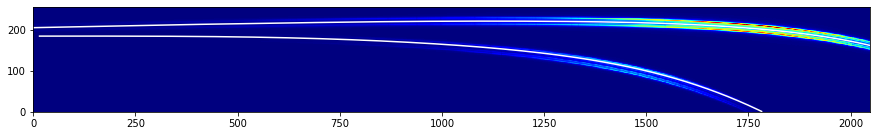

In [8]:
xM1, yM1 = tm.rot_om2det(ang, xanch, yanch, xOM1, yOM1, bound=True)
xM2, yM2 = tm.rot_om2det(ang, xanch, yanch, xOM2, yOM2, order=2, bound=True)

plt.figure(figsize=(15,3))
plt.imshow(clear, origin='lower', cmap='jet')
plt.plot(xM1, yM1, c='white')
plt.plot(xM2, yM2, c='white')

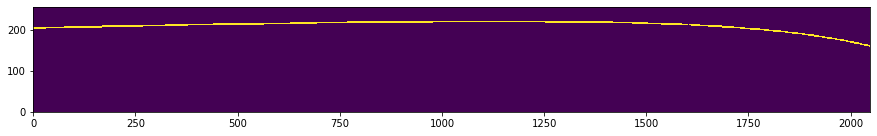

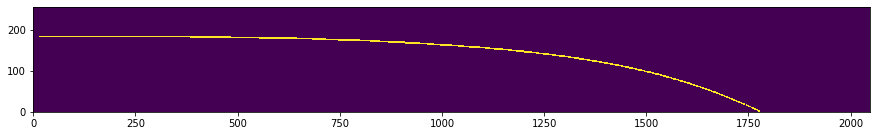

In [9]:
xM1 = xM1.astype(int)
xM2 = xM2.astype(int)
yM1 = yM1.astype(int)
yM2 = yM2.astype(int)

P1, P2 = np.zeros((256, 2048)), np.zeros((256, 2048))
for x, y in zip(xM1, yM1):
    P1[y-2:y+2, x] = 1
for x, y in zip(xM2, yM2):
    P2[y-2:y+2, x] = 1
    
plt.figure(figsize=(15,3))
plt.imshow(P1, origin='lower')

plt.figure(figsize=(15,3))
plt.imshow(P2, origin='lower')

## Extraction

In [12]:
# Read relevant files
wv_1 = fits.open("Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("Ref_files/wavelengths_m2.fits")[0].data
T1 = tracemodel_wf277  # fits.open("Ref_files/trace_profile_m1.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
T1 = T1.astype(float)

T1 = T1 / T1.sum(axis=0)
T1[np.isnan(T1)] = 0.

In [13]:
lam_grid = get_soss_grid([P1, P2], [wv_1, wv_2], n_os=1)
# This basically just gets the wavelength at the trace CoM in each column.
# The second order is preferred in wvelength region where the two overlap due to higher spectral resolution.

In [15]:
extra = TrpzOverlap([T1], [wv_1], orders=[0], scidata=clear, lam_grid=lam_grid, thresh=1e-9,
                    c_kwargs={'thresh':0.0001})

In [16]:
f_k = extra.extract()
rebuilt = extra.rebuild(f_k)

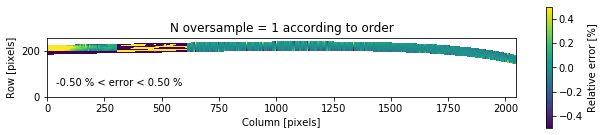

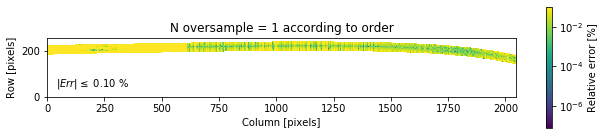

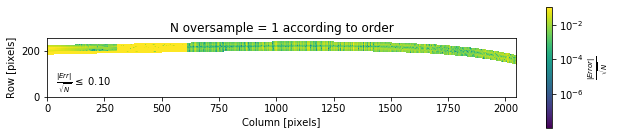

In [17]:
scidata = clear

# Look at errors
n_oversample=1
plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow((rebuilt-scidata)/scidata * 100, origin='lower', vmin=-0.5, vmax=0.5)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,46, "{:.2f} % < error < {:.2f} %".format(cmap.vmin, cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/scidata * 100, norm=LogNorm(), origin='lower', vmax=1e-1)
cmap = plt.colorbar(label="Relative error [%]")
plt.text(40,46, r"$| Err | \leq$" + " {:.2f} %".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

plt.figure(figsize=(9,2))
plt.title("N oversample = {} according to order".format(n_oversample))
plt.imshow(np.abs(rebuilt-scidata)/np.sqrt(scidata),norm=LogNorm(), origin='lower', vmax=1e-1)
cmap = plt.colorbar(label=r"$\frac{| Error |}{\sqrt{N}}$")
plt.text(40,46, r"$\frac{|Err|}{\sqrt{N}} \leq$" + " {:.2f}".format(cmap.vmax))
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
plt.tight_layout()

## Isolate Order 2

In [37]:
O2frame = tm.mask_order1(scidata-rebuilt, flat_samples, xOM2, yOM2, order=2)
for i in range(15):
    O2frame[:,i] = O2frame[:,15]
O2frame[O2frame < 0] = 0
O2frame[np.isnan(O2frame)] = 0

In [18]:
scidata[np.isnan(scidata)] = 0.
rebuilt[np.isnan(rebuilt)] = 0.

frame = scidata - rebuilt
mask = np.zeros([256, 2048])

xx = xM2.astype(int)
yy = yM2.astype(int)
xr = np.linspace(np.min(xx), np.max(xx), np.max(xx)+1).astype(int)

# Set all pixels within the extent of the order 1 trace to 1 in the mask.
for xxx, yyy in zip(xr, yy):
    mask[(yyy-21):(yyy+20), xxx] = 1
for i in range(15):
    mask[:,i] = mask[:,15]

O2frame = (mask * frame) / np.nanmax(mask*frame, axis=0)
O2frame[O2frame < 0] = 0
O2frame[np.isnan(O2frame)] = 0

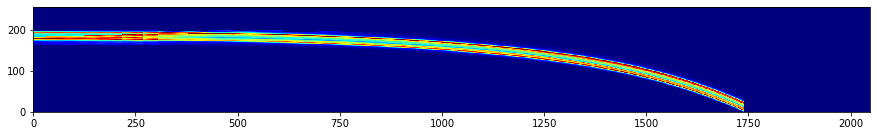

In [39]:
plt.imshow(O2frame, origin='lower', cmap='jet')